# Classifying bird calls by species - Project Milestone 5


## Kate Bowers, Ezra Feder, Grayson Martin, Kaleo Mungin, Kevin Zhang - Group #51

## Table of Contents
* [1. Problem Definition](#one)
    * [1.1 Flow Chart](#one-one)
    * [1.2 Code and Dependencies](#one-two)
* [2. Data handling](#two)
* [3. EDA: Exploratory data analysis](#three)
* [4. Modeling approach and decisions](#four)
    * [4.1 Subsection 1](#four_one)
    * [4.2 Subsection 1](#four-two)
    * [4.3 Subsection 1](#four-three)
* [5. Results](#five)
    * [5.1 Conclusions and speculations](#five-one)
    * [5.2 Error analysis](#five-two)
    * [5.3 Strengths and limitations](#five-three)
    * [5.4 Future **directions**](#five-four)


## 1. Problem Definition <a class="anchor" id="one"></a>



**The process of classifying bird audio could benefit from machine learning models. While expert opinion is useful, incorporating it alongside a vast repertoire of data may be helpful. How can we develop an accurate and robust machine learning model to classify bird species from variable-quality field recordings, given the wide range of bird call types and recording durations present in our dataset?**

We're using a subset of data that was collected and hosted by Xeno-Canto. Given that the original dataset has over 700k audio recordings and thousands of different species accross the globe, we narrowed the project scope to classify the top 10 most frequent species in Europe. As we'll see within this notebook, the lessons learned from this subset could be applied to the understanding and development of more powerful models. This includes the insights gathered from EDA, the coding modules and techniques, the data preprocessing steps, and the modelling process.

## 1.1 Flow Chart  <a class="anchor" id="one-one"></a>
**The flow chart below describes the course of our project:**

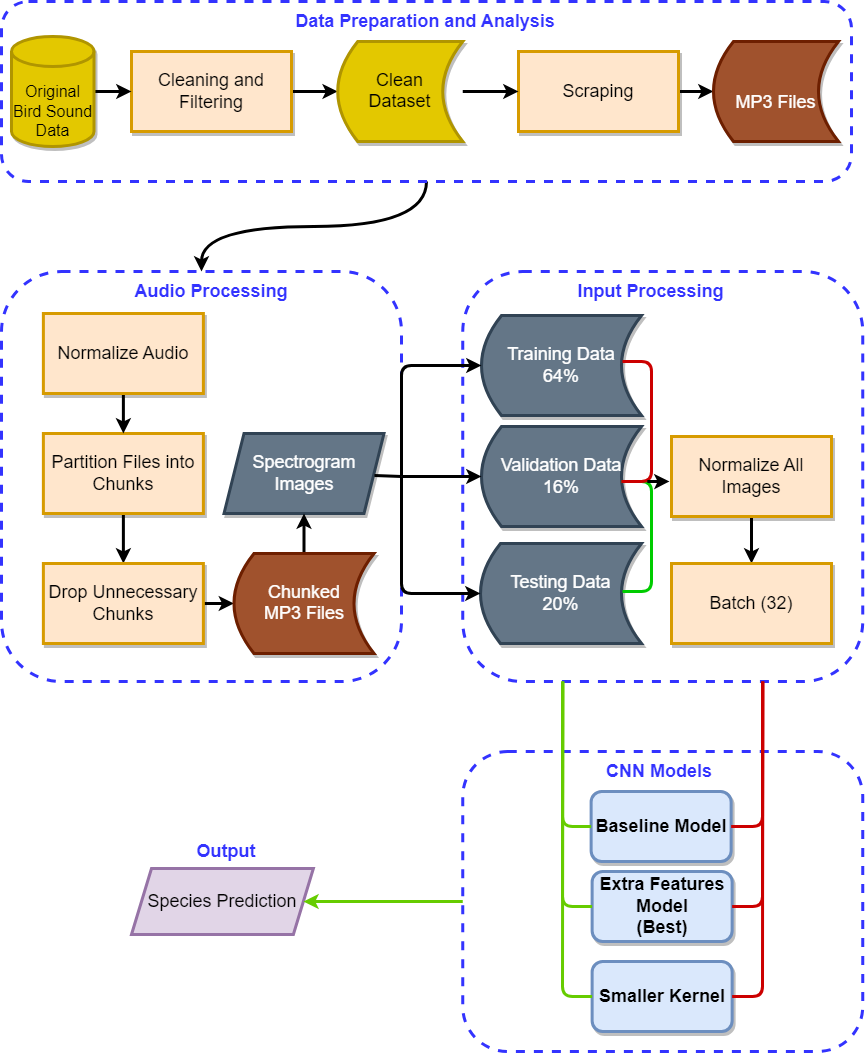

## 1.2 Code and Dependencies  <a class="anchor" id="one-two"></a>
We have many notebooks in the **additional_notebooks** folder that do the following. We will refer to these notebooks from time to time throughout our report, as some of the code and exposition has been done in these notebooks instead of the master final notebook.

- MS2.ipynb: Notebook with code for scraping dataset from Xeno-Canto![heatmaps_ms5.png](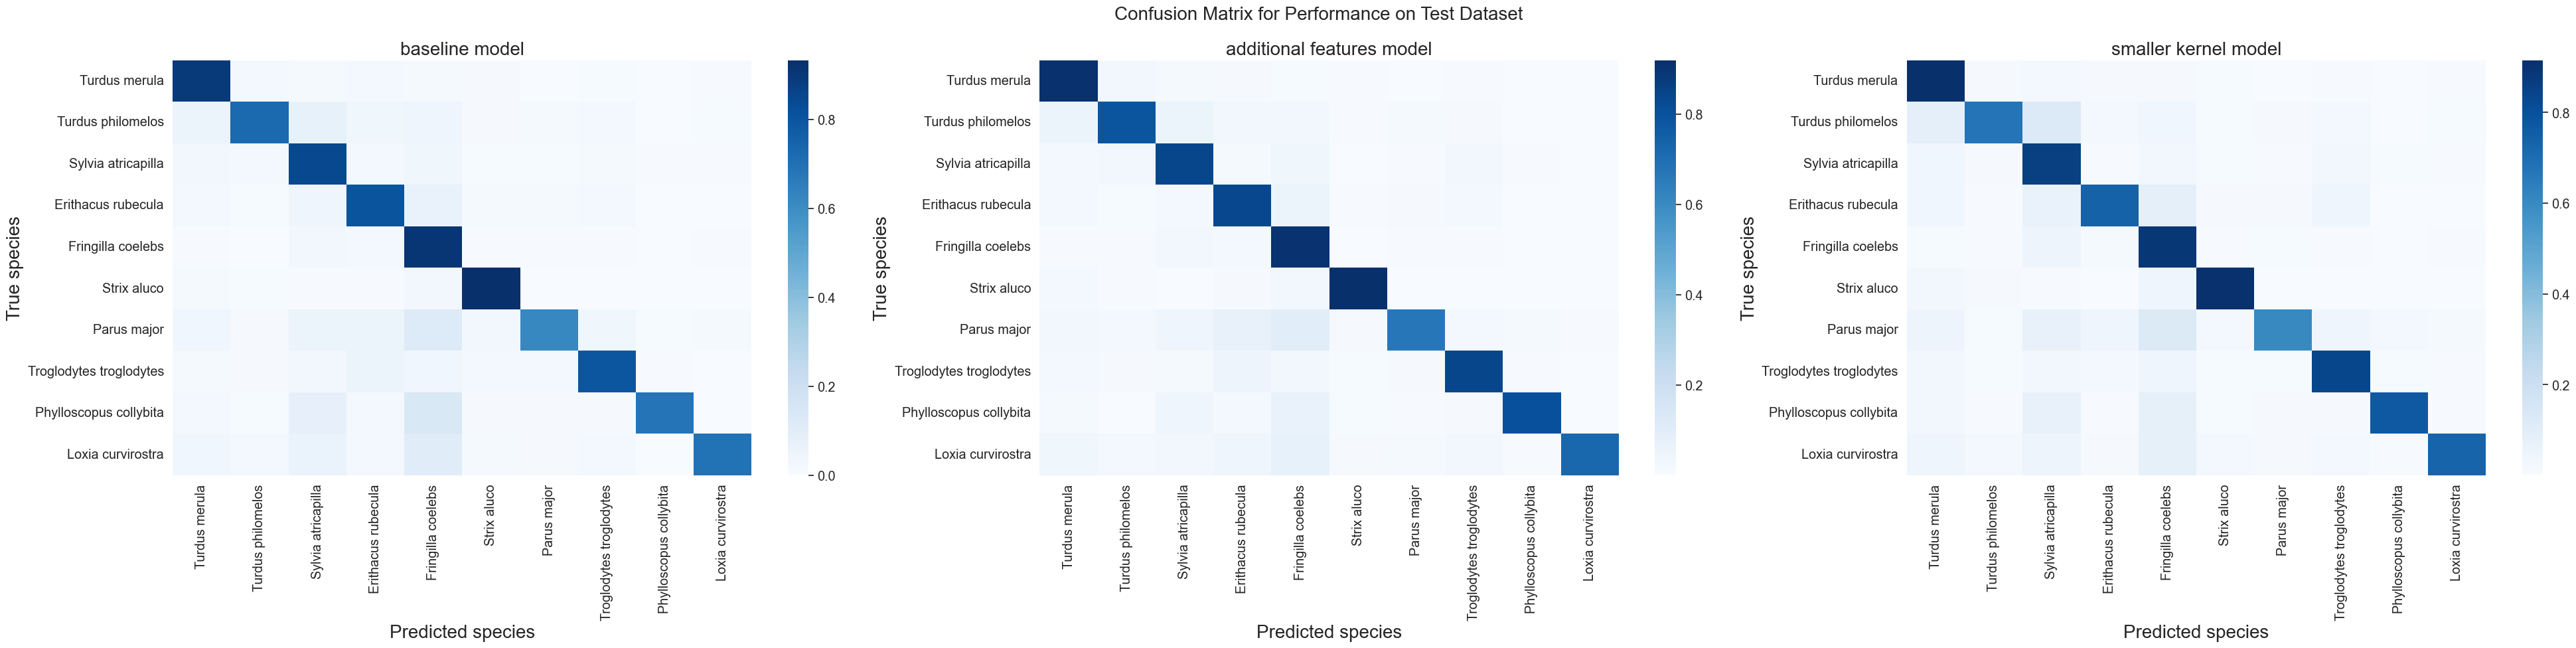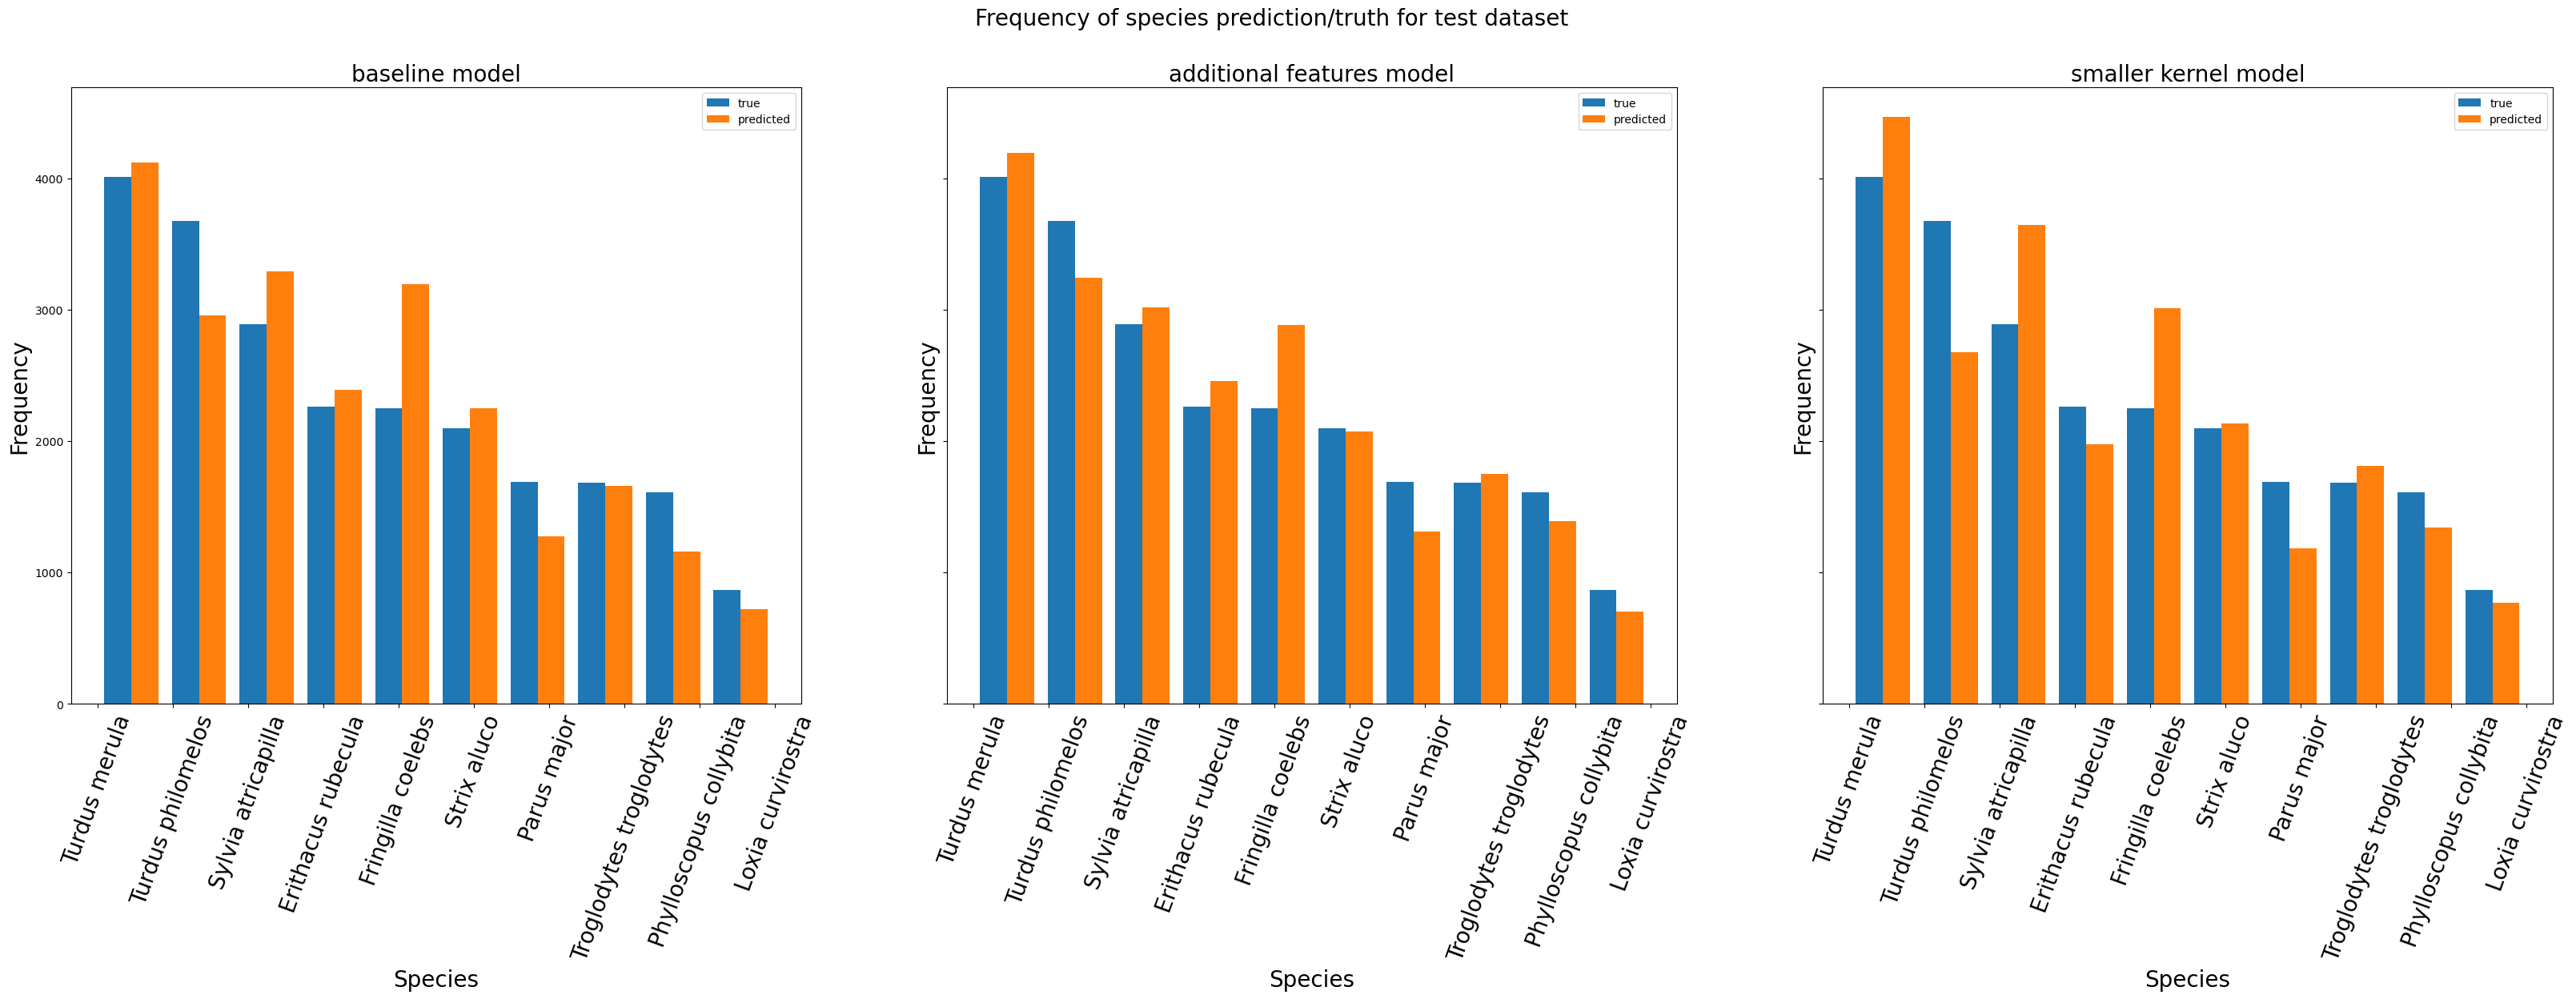)
- MS5_audio_bird_eda.ipynb: EDA on Europe dataset and audio, including RMS tuning
- MS5-spectrogram-generation.ipynb: Notebook to chunk and filter mp3s, and then generate all the spectrograms.
- MS5_data_preprocessing_final.ipynb: Notebook to construct the tensorflow dataset without additional features and one hot encode the labels
- MS5_data_preprocessing_additional_features_final.ipynb: Notebook to construct tensorflow dataset with additional features
- MS5_training-baseline.ipynb: Notebook to train baseline model
- MS5_training-smaller-kernel.ipynb: Notebook to train smaller kernel model
- MS5_training-other-features.ipynb: Notebook to train model with other features
- fine_tuning.ipynb: Notebook to perform fine-tuning of EfficientNet
- MS5_error_analysis.ipynb: Notebook to compute error analysis

This code depends on os, pathlib, time, zipfile, tarfile, imageio, matplotlib, numpy, pickle, time, PIL.Image, scipy, tensorflow, keras, tqdm, sklearn, pandas, librosa, seaborn, and Google colab.

## 2. Data Handling  <a class="anchor" id="two"></a>


The dataset is downloaded from xeno-canto; the csv file for the dataset consists of ~700k data entries. Potentially important features included behavior (call sound or song sound), location features, time and seasonal features, and method of observation features. The response variable in the data set is the species name; although there are other potential response variables, (i.e. genus, verbatim species), we felt like species was the most fitting, and that is what prior work has done as well. In order to filter the data for our use case, we first filter to only use recordings from Europe. We then filter any rows that do not have a species name present. Now that we have the Europe only data, we further filter the dataset to only contain the top 10 most frequent species recorded in Europe. These species are *Turdus merula, Turdus philomelos, Sylvia atricapilla, Erithacus rubecula, Fringilla coelebs, Strix aluco, Parus major, Troglodytes troglodytes, Phylloscopus collybita, and Loxia curvirostra.*
We then download the mp3s from the website using the catalogNumber column present in the dataset. The code for filtering is contained in **additional_notebooks/MS5-spectrogram-generation.ipynb**, and the code for scraping the mp3s is in MS2.ipynb. There is further description in the aforementioned notebooks.

## 3. EDA: Exploratory data analysis  <a class="anchor" id="three"></a>

We perform EDA on the dataset, restricted to birds in Europe. We first visualize the amount of class imbalance that is present among the top 10 species.

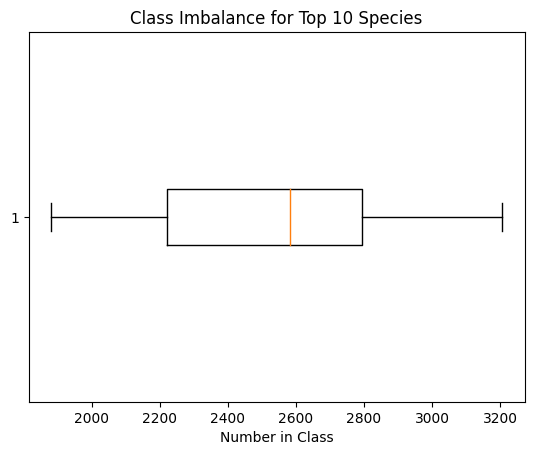



As we can see, there is quite a bit of class imbalance. As a result, we decided to undersample the data so that all classes had the same frequency as the least frequent class (1881). We were still left with 18810 data entries to work with, which would be plenty.

After we undersampled the data, we needed to convert the scraped mp3 data to a format that our CNN can learn on. We broke up each audio file into 5 second chunks; since audio files can be many different lengths, doing so gives a consistent time scale for our model to learn the audio. Additionally, since bird audio is typically a repetitive noise, splitting it into chunks should still capture the most important parts of the audio for the classification. Now that we have split the audio into chunks, some of the chunks may be essentially silent. As a result, we compare the RMS of a chunk, which measures the amount of audio signal in the chunk, with a hand tuned threshold of 0.01. 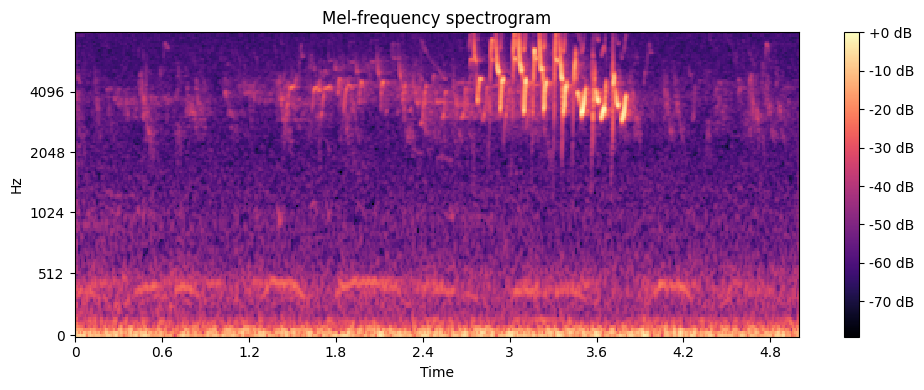

Shown is the spectrogram for a data entry with a RMS close to the threshold. As we can see, there is still meaningful audio data in the spectrogram; RMS lower than 0.01 seemed to allow more empty audio data into the dataset.

Each spectrogram is converted into a numpy array and normalized, and then stored into a file.

The file this EDA is performed in is **additional_notebooks/MS5_audio_bird_eda.ipynb** and the spectrograms are generated in **additional_notebooks/MS5-spectrogram-generation.ipynb**


Additionally, we would like to incorporate additional features into our modeling. The features we chose were latitude, longitude, elevation, month, and whether the recording was human or machine observed. The EDA for these features is in notebook **additional_notebooks/MS5_data_preprocessing_additional_features_final.ipynb**
We impute missing latitudes, longitudes, and elevations by the average of the country the recording was in. The month is imputed by just replacing null values with 0. There were no missing values for human or machine observed.

These additional features are then standardized and added to the dataset.


The species labels for each chunk is one hot encoded, and the encoding is saved so we can refer back to it later. Both train, val, and test datasets are constructed by performing a 80/20 split for train/test, and then an additional 80/20 split for train/val; both splits are stratified on the species label. These tensorflow datasets, one dataset for just the spectrogram, and one dataset for the spectrogram with additional features, are stored to file so we can use them on separate machines (done in **additional_notebooks/MS5_data_preprocessing_final.ipynb** and **additional_notebooks/MS5_data_preprocessing_additional_features_final.ipynb** respectively).

## 4. Modeling approach and decisions  <a class="anchor" id="four"></a>

### 4.1 The Baseline Model and a Variation <a class="anchor" id="four_one"></a>


Our first model is a deep CNN with 4 convolutional layers. The code definition of the model is shown below. This model was inspired by bird audio work by Piczak. One important thing to note is that the kernel in the first layer is the same height as the input: this is because our images, which are spectrograms, don't have vertical invariance; the vertical location of a pattern determines the frequency, which is important for classifying the bird. However, we do have horizontal invariance, since we expect the same noise happening at different times to still lead to the same classification. Thus, our kernel is "skinny". The drop out layer before the output helps to avoid overfitting, as well as the regulaizer output. layer.

In [ ]:
Piczak_model_2 = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(128, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

We train with a maximum of 20 epochs, a batch size of 32, and adam optimizer with lr = 0.001, and a categorical cross entropy loss. We use early stopping with a patience of 3 to avoid overfitting. The training history is shown below:
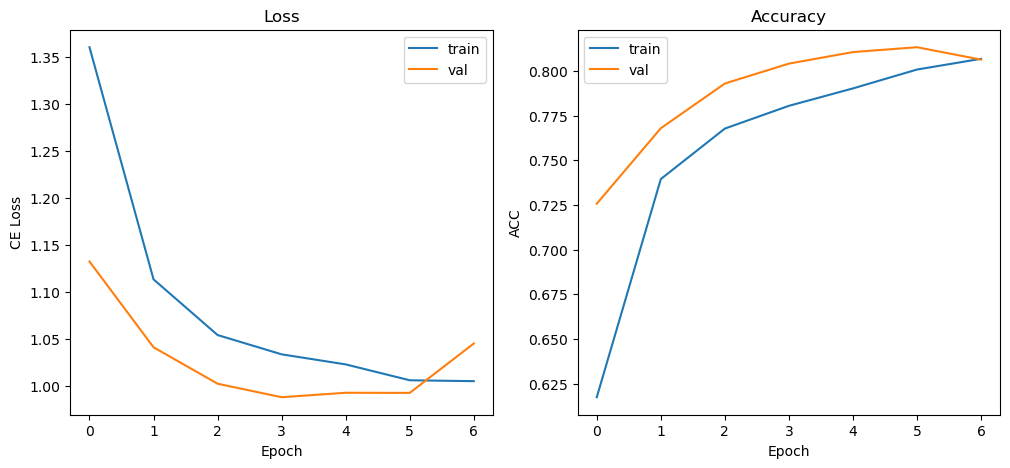

We can see that we start overfitting around epoch 3, when the validation loss begins to increase. Our validation accuracy hovers around 0.8. When evaluated on the test set, we have a test loss of 1.0343 and a test accuracy of 0.8088

We then tried a slightly smaller kernel height, 3 pixels smaller than the input image height. The intuition here is that some variation in frequency should be invariant, as the same call with a very slightly different pitch should be classified as the same thing. The code for the model is shown below.

In [ ]:
Piczak_model_2 = Sequential([
    # First convolutional layer with 80 filters
    Conv2D(80, kernel_size=(125, 6), padding='same', input_shape=(128, 431, 1)),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(4, 6)),

    # Second convolutional layer with 160 filters
    Conv2D(160, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),

    # Max pooling
    MaxPooling2D(pool_size=(1, 2)),

    # Continue the pattern...
    Conv2D(240, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    Conv2D(320, kernel_size=(1, 2), padding='same'),
    LeakyReLU(alpha=0.3),
    MaxPooling2D(pool_size=(1, 2)),

    # Flatten the output of the conv layers to connect it with dense layers
    Flatten(),

    # Dropout layer
    Dropout(0.5),

    # Output layer with softmax activation
    Dense(10, activation='softmax', kernel_regularizer=L2(0.001))
])

Piczak_model_2.summary()

We run the same training configuration, and the training history is shown below.
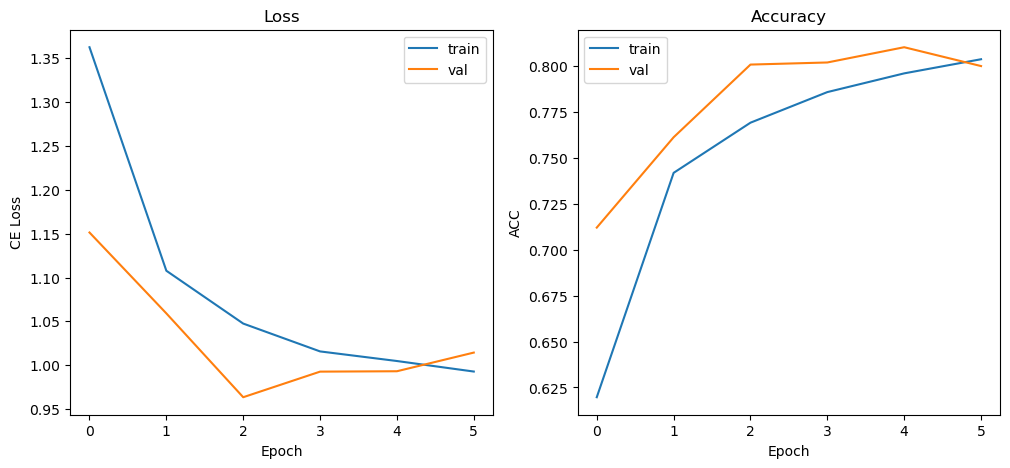

As we can see, the validation loss hits a minumum after 3 epochs, and our validation accuracy once again hovers around 0.8.

On the test set, our model with a slightly smaller kernel has a test loss of 1.011 and a test accuracy of 0.8038. Thus,a smaller kernel performs pretty comparably to the original baseline model, which indicates that allowing some variation in the frequency domain does not significantly improve the model.

The full code for the baseline model is in **additional_notebooks/MS5_training-baseline.ipynb**, and the full code for the model with the smaller kernel is in **additional_notebooks/MS5_training-smaller-kernel.ipynb**

### 4.2 Incorporating other features into the model <a class="anchor" id="four-two"></a>

Our third model incorporates the 5 other features (latitude, longitude, elevation, month, isHumanObservation) by using dataset 2. To do this, we take the CNN architecture from before, right before the final classification layer. We run a feed forward network in parallel that takes in as input the vector of 5 features. We then concatenate the results of the two architectures running in parallel and feed the concatenated vector into the final output classification layer. The code is shown below, which utilizes the functional model.

In [ ]:
input_img = tf.keras.Input((128, 431, 1), name='image_input')
first_conv = Conv2D(80, kernel_size=(125, 6), padding='same')(input_img)
first_rlu = LeakyReLU(alpha=0.3)(first_conv)
first_pool = MaxPooling2D(pool_size=(4, 6))(first_rlu)
second_conv = Conv2D(160, kernel_size=(1, 2), padding='same')(first_pool)
second_rlu = LeakyReLU(alpha=0.3)(second_conv)
second_pool = MaxPooling2D(pool_size=(1, 2))(second_rlu)
third_conv = Conv2D(240, kernel_size=(1, 2), padding='same')(second_pool)
third_rlu = LeakyReLU(alpha=0.3)(third_conv)
third_pool =  MaxPooling2D(pool_size=(1, 2))(third_rlu)
fourth_conv = Conv2D(320, kernel_size=(1, 2), padding='same')(third_pool)
fourth_rlu = LeakyReLU(alpha=0.3)(fourth_conv)
fourth_pool =  MaxPooling2D(pool_size=(1, 2))(fourth_rlu)
flatten = Flatten()(fourth_pool)
dropout = Dropout(0.5)(flatten)
input_features = tf.keras.Input(5, name='feature_input')
dense3 = Dense(100, activation='relu')(input_features)
dense6 = Dense(100, activation='relu')(dense3)
dropout3 = Dropout(0.5)(dense6)
dense4 = Dense(100, activation='relu')(dropout3)
dense5 = Dense(100, activation='relu')(dense4)
dropout4 = Dropout(0.5)(dense5)
concat = tf.keras.layers.Concatenate()([dropout, dropout4])
output= Dense(10, activation='softmax', kernel_regularizer=L2(0.001))(concat)

Piczak_model_2 = Model(inputs =[input_img, input_features], outputs=output)

Wp kept the training setup the same as the previous models, and it worked well. The training history is shown below: 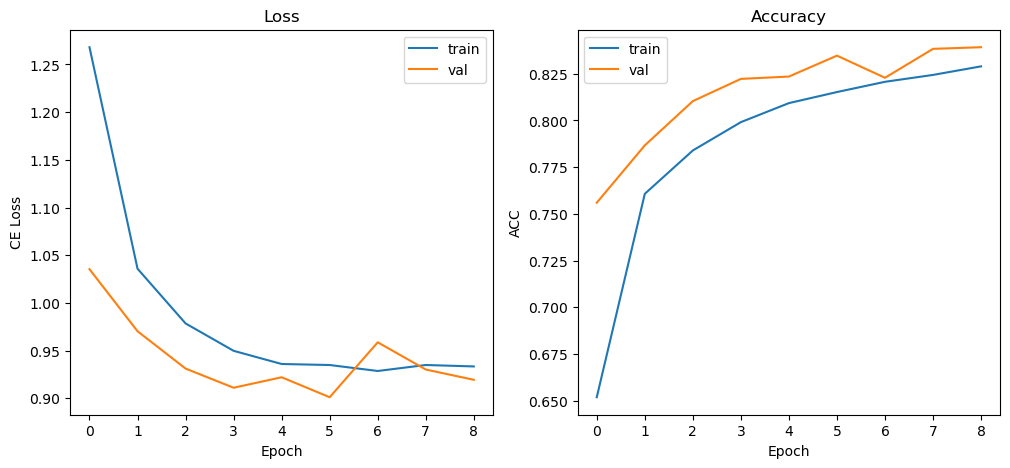

The model begins overfitting around epoch 5 as the validation loss starts increasing, but we have increased our accuracy by around 4% compared to the baseline model. Looking at our performance on the test set, the test loss for this model is 0.9146 and the test accuracy is 0.84. Thus, we can see that this model performs better both by the loss and accuracy metrics on the test set when compared to the other models. As expected, including other features can help the model with the classification task.


The full code for this model is in **additional_notebooks/MS5_training-other-features.ipynb**

### 4.3 Fine-Tuning EfficientNet  <a class="anchor" id="four-three"></a>


We were interested in approaching this problem with transfer learning as well, fine-tuning EfficientNet to analyze our spectrograms. EfficientNet is a very effective image classification model, but it is trained on common images so we were apprehensive about its application to our audio spectrogram analysis.

Stack our normalized images to get the three channels needed as EfficientNet input

In [ ]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    normalized = normalize_image(img)
    stacked = tf.stack([normalized]*3, axis=-1)
    return stacked, label

Create the model by appending two dense layers to the EfficientNet Flatten() layer

In [ ]:
# Load pre-trained EfficientNetB0
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 431, 3))
x = base_model.output
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.35)(x)
predictions = Dense(10, activation='softmax')(x)

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 431, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 431, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 431, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 431, 3)          0         ['normalization[0][0]']   

Train first on just the dense layers then on all layers with a lower learning rate. Utilizes gradient clipping, early stopping, and a learning rate scheduler that reduces the learning rate upon a plateau.

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
initial_epochs = 5
full_epochs = 15

base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-08, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
head_history = model.fit(train_dataset, epochs=initial_epochs, validation_data=val_dataset)

base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5, epsilon=1e-08, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

full_model_history = model.fit(train_dataset, initial_epoch=initial_epochs, epochs=initial_epochs+full_epochs, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/5


2024-05-08 07:07:23.340511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-08 07:07:23.985861: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 07:07:24.532601: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-08 07:07:24.652418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 07:07:25.963582: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff87d051700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 07:07:25.963627: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Cap

2303/2303 [==============================] - 208s 85ms/step - loss: 2.3699 - accuracy: 0.1711 - val_loss: 2.2244 - val_accuracy: 0.1595
Epoch 2/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2259 - accuracy: 0.1729 - val_loss: 2.2242 - val_accuracy: 0.1595
Epoch 3/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2246 - accuracy: 0.1736 - val_loss: 2.2238 - val_accuracy: 0.1595
Epoch 4/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2243 - accuracy: 0.1734 - val_loss: 2.2237 - val_accuracy: 0.1595
Epoch 5/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2245 - accuracy: 0.1736 - val_loss: 2.2236 - val_accuracy: 0.1743
Epoch 6/20


2024-05-08 07:23:54.960683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2303/2303 [==============================] - 718s 291ms/step - loss: 1.9651 - accuracy: 0.1837 - val_loss: 2.2479 - val_accuracy: 0.1595 - lr: 5.0000e-05
Epoch 7/20
2303/2303 [==============================] - 672s 292ms/step - loss: 1.8521 - accuracy: 0.2259 - val_loss: 2.2543 - val_accuracy: 0.1595 - lr: 5.0000e-05
Epoch 8/20
2303/2303 [==============================] - 671s 291ms/step - loss: 1.7693 - accuracy: 0.2730 - val_loss: 185.7931 - val_accuracy: 0.1743 - lr: 5.0000e-05
Epoch 9/20
2303/2303 [==============================] - 671s 292ms/step - loss: 1.6753 - accuracy: 0.3390 - val_loss: 2.1852 - val_accuracy: 0.1956 - lr: 5.0000e-05
Epoch 10/20
2303/2303 [==============================] - 671s 291ms/step - loss: 1.5701 - accuracy: 0.3702 - val_loss: 2.3783 - val_accuracy: 0.0983 - lr: 5.0000e-05
Epoch 11/20
2303/2303 [==============================] - 671s 292ms/step - loss: 1.5145 - accuracy: 0.4161 - val_loss: 1.9899 - val_accuracy: 0.2765 - lr: 5.0000e-05
Epoch 12/20
2303/

Below is the generated training history for the model. We can clearly see the model is not performing well. Training accuracy plateaus around 60% beyond 10 epochs (the fifth full model epoch), but validation accuracy varies greatly across epochs. We think this may be because of the nature of our classification problem. Generating classes based on spectrograms is a very niche problem with smaller changes in detail than the imagenet set that EfficientNet is trained on. Further, the first convolutional layer of EfficientNet is not of the desired shape (a tall, skinny rectangle) for this type of classification that we describe above.

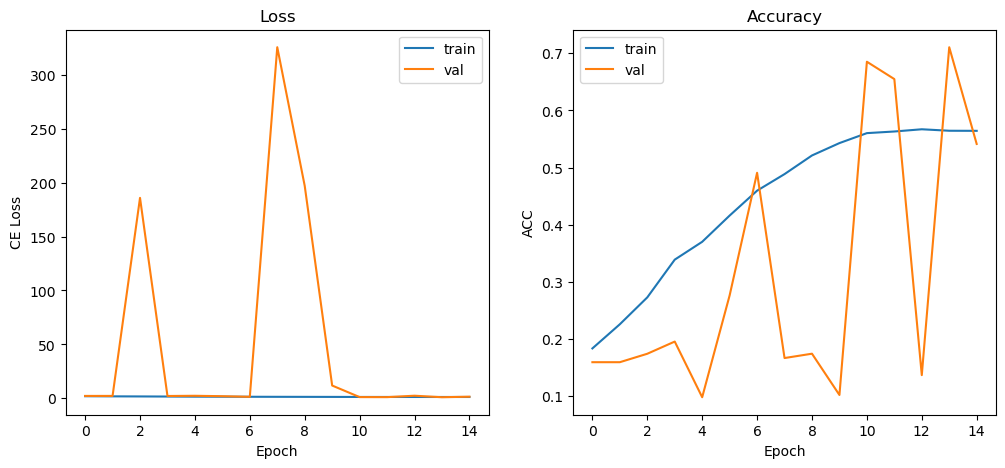

In [ ]:
plot_hist(full_model_history)

Below we see the expectedly poor performance of the fine-tuned model on the testing set. We expect that this overall poor performance is due to the major differences between our spectrogram dataset and the dataset that EfficientNet is trained on: more than fine tuning is necessary to make a model for classifying spectrograms. The features and shapes in the spectrograms are very different than those in a more general image classification dataset.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

720/720 [==============================] - 45s 62ms/step - loss: 1.4301 - accuracy: 0.5455
Test Loss: 1.4300833940505981
Test Accuracy: 0.5455137491226196


## 5. Results  <a class="anchor" id="five"></a>

### 5.1 Conclusions<a class="anchor" id="five-one"></a>

In conclusion, we compare the performance of all of our models below. We can see that fine tuning EfficientNet was not a reasonable approach. The baseline model was massively improved by the addition of more features, like location data and month of recording, which lowered misclassification overall.

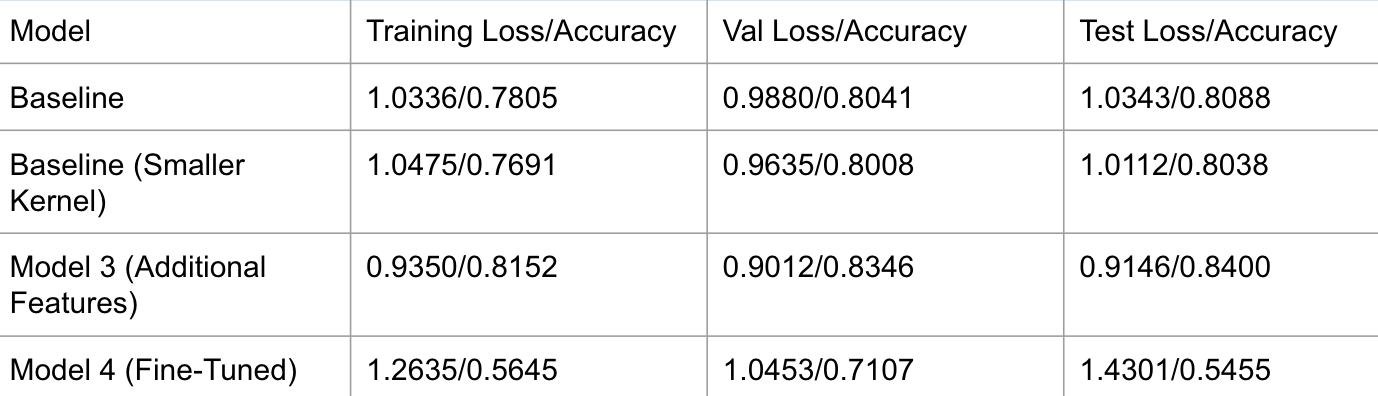

### 5.2 Error analysis  <a class="anchor" id="five-two"></a>

We analyzed model performance and error on the test dataset with the sklearn.metrics.classification_report method to examine F1 scores, precision, and recall, shown below. We analyze the baseline model and additional features model below to show the strong effect of the added features.
We see across the board that the additional features model has the highest f1 scores, indicating the best performance, and that species 4 (Fringilla coelebs, the Eurasian chaffinch) has the lowest precision and the highest recall. This means that non-chaffinch birds are often misclassified as chaffinches, but the model is very reliable at identifying chaffinches.

![classification_ms5.png](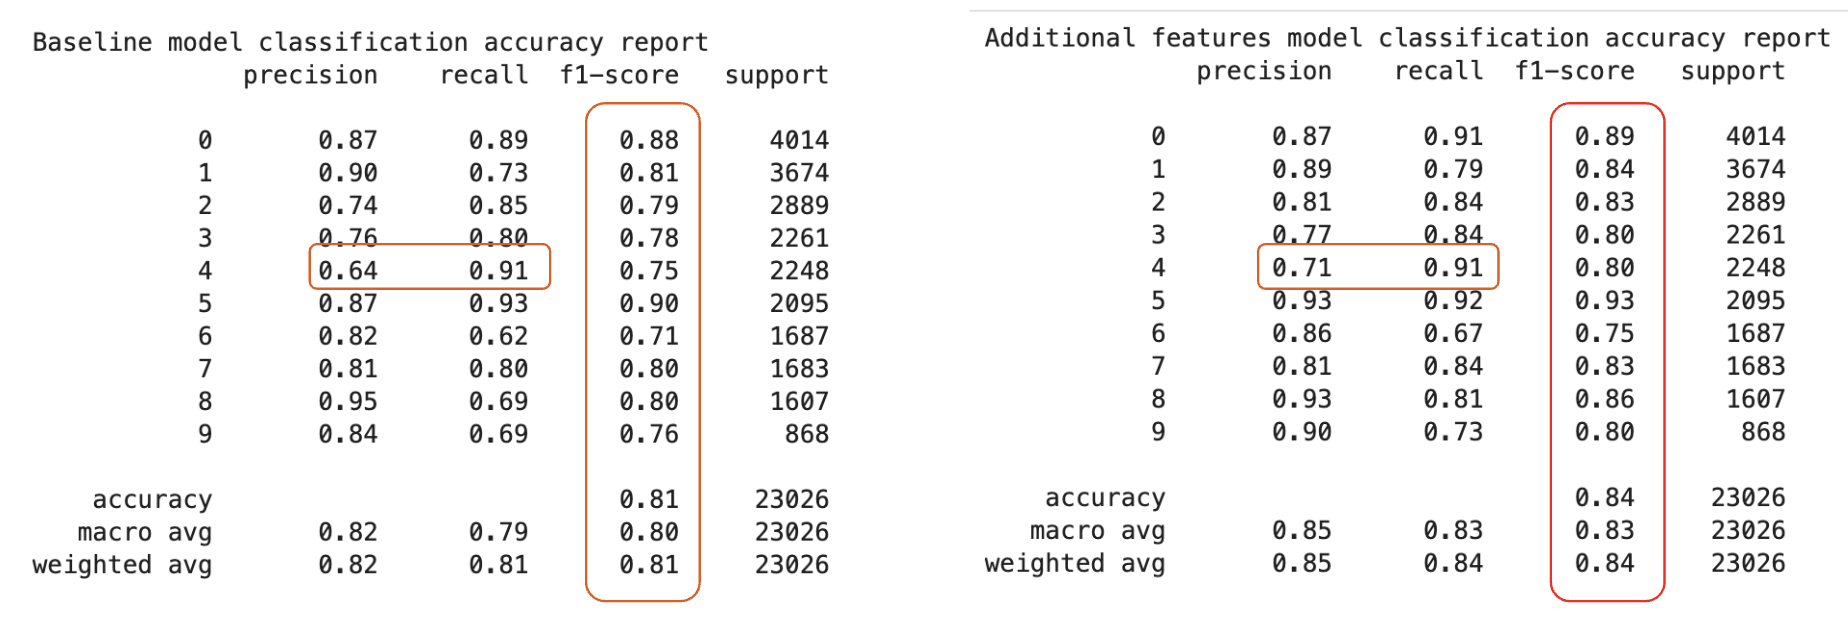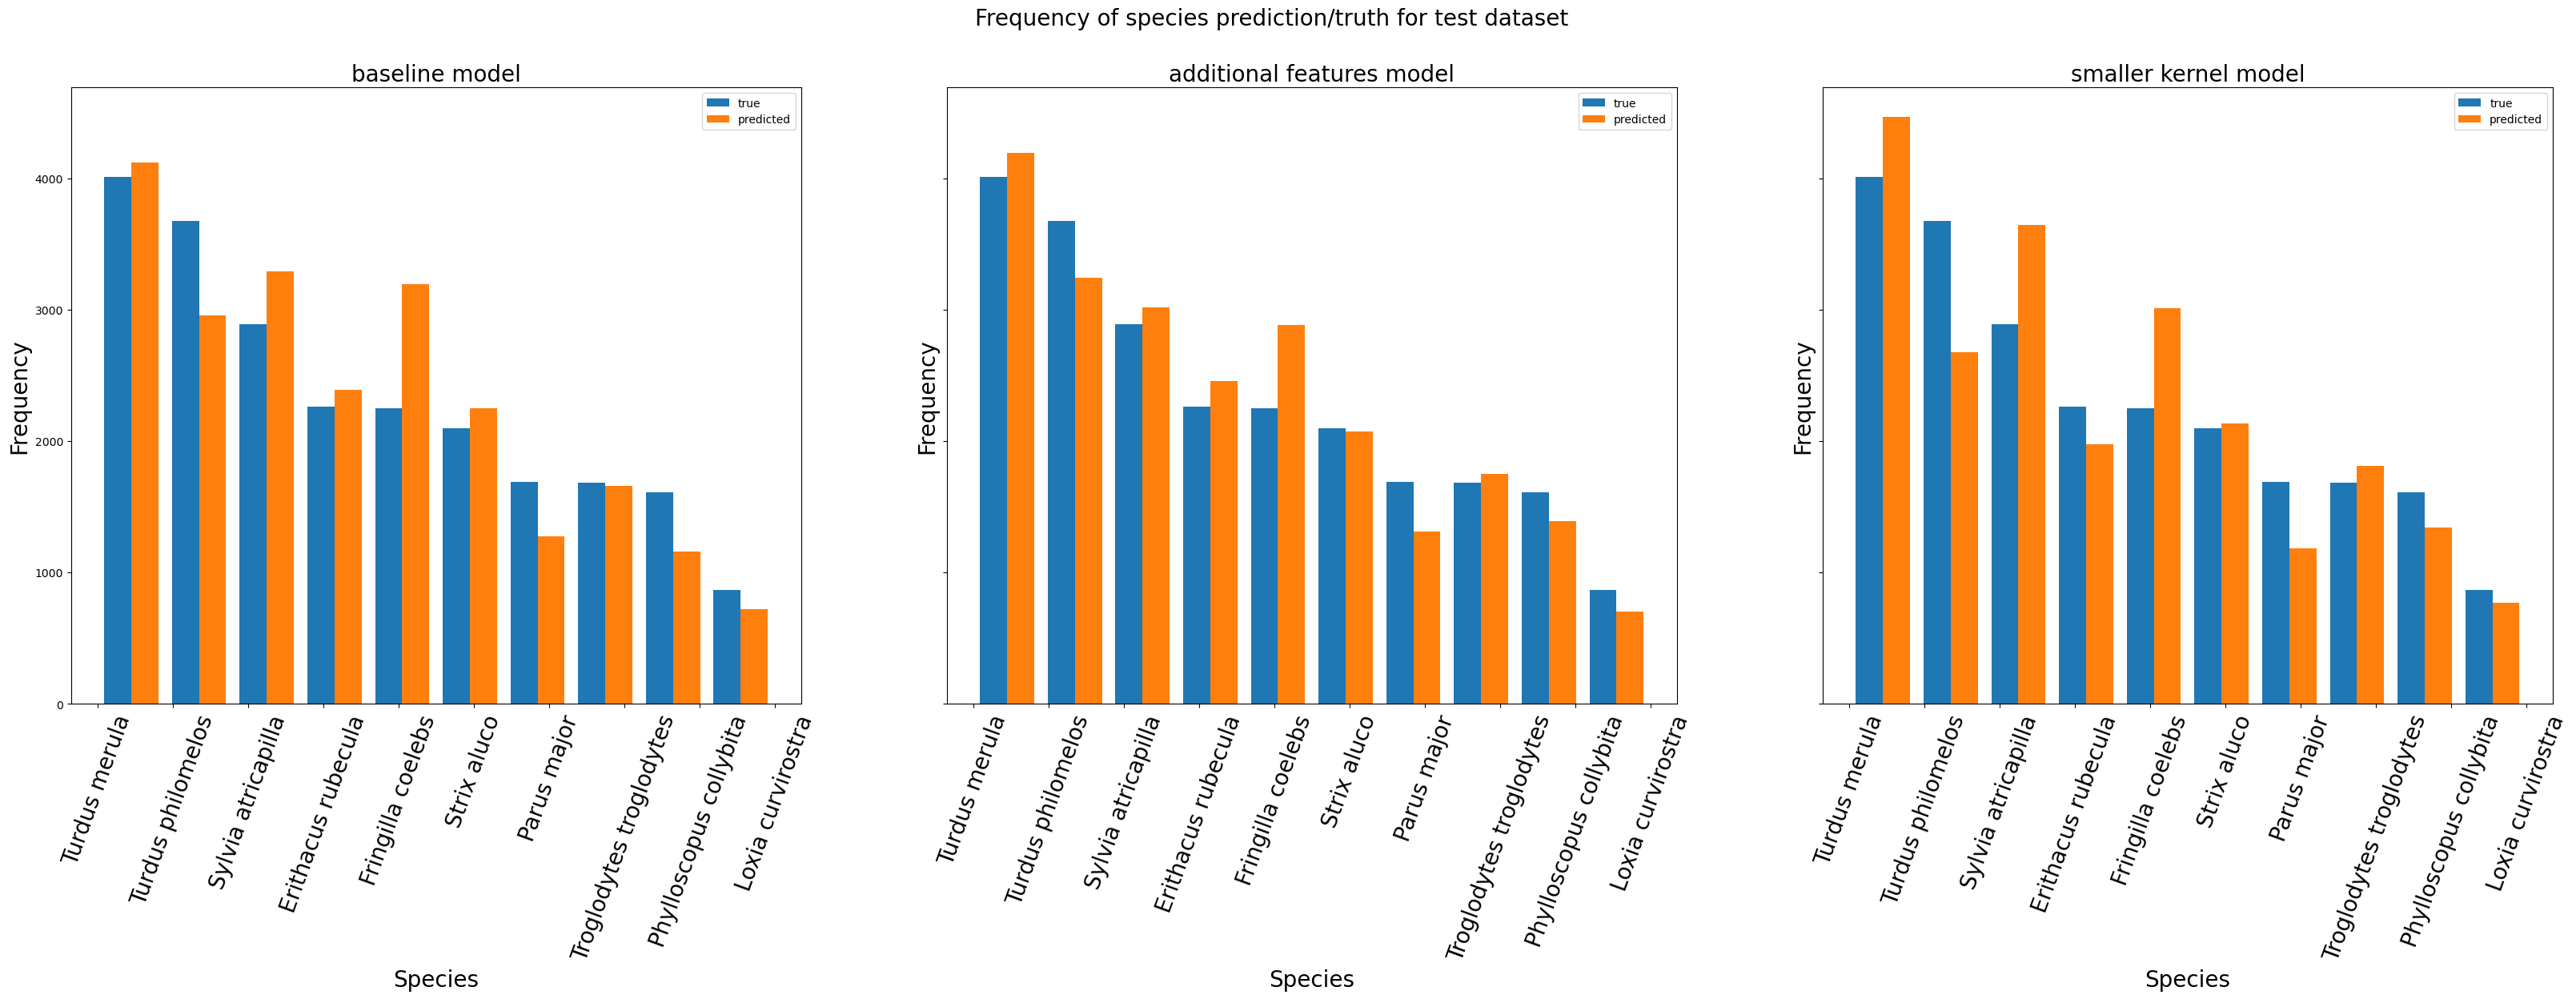)

We were curious about why chaffinches had such low precision, and made the below histograms to compare the frequency of true and predicted species labels across different models. The baseline model clearly over-predicts Fringilla coelebs, with a large gap between true and predicted model frequency, and this gap is smaller in the additional features model. The additional features model has improved precision on chaffinch classification and all species classification overall.



Image: histograms_ms5.png

We also made confusion matrix heatmaps for each model's performance on the test dataset, which reflect these patterns in misclassification. While the baseline model has most common misclassification in Fringilla coebels, Erithacus rubecula, and Sylvia atricapilla, it is also common in the small kernel model. There are fewer misclassifications in the additional features model.

Image: heatmaps_ms5.png

Saliency maps were created to understand what information the model found most important when classifying the image as a particular species. Perhaps unsurprisingly, the brightest (loudest) parts of the picture were most significant for classification. Perhaps more interestingly, there seemed to be a somewhat vertical rather than horizontal pattern in the saliency maps, suggesting that the models identify distinct moments of sound rather than the continuous cadence. Below is an example of a saliency map from the baseline model, but more results and pertinent code can be found in saliency_maps.ipynb.
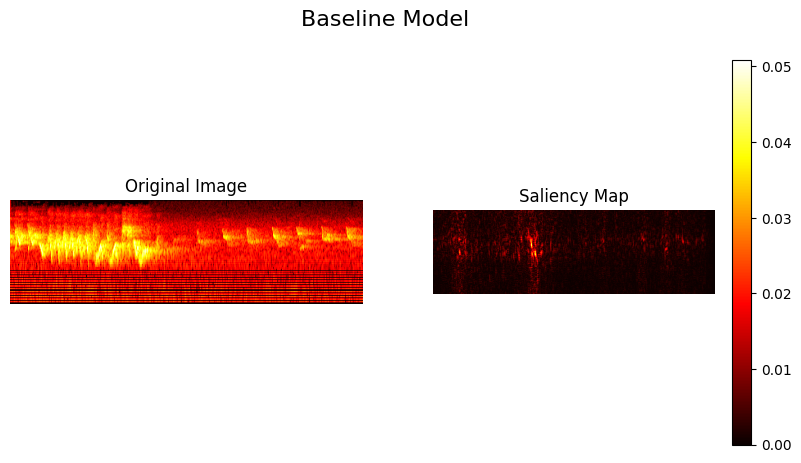

### 5.3 Strengths and limitations  <a class="anchor" id="five-three"></a>

This project exemplified many strengths. It designed multiple models with high (>80%) accuracy rates. This shows that neural networks can be practically used to identify various bird calls. It also shows that meta-data like the location of the bird recording is helpful in continuing to improve the accuracy of the model.

Our models were also strong in that they did not perpetuate the same predictable errors. For example, although some classes such as class 4 (the Eurasian Chaffinch) received slightly more false positive predictions, overall they were quite balanced. This is likely because we avoided large data imbalances, and helps to make sure the model is not biased towards oversampled species.

While this model has many strengths, it also has some limitations. The 80+% accuracy could still be higher. While the model is usually correct, about one-fifth of the time it makes a mistake, meaning there is still a ways to go in terms of making it a reliable tool. Moreover, the model is limited to the top ten most common species in Europe. While a useful tool for such species, the model is somewhat limited and would benefit from being applicable to all species in Europe and even throughout the world.

We were limited in terms of the data we could use. Although the dataset we utilized had over 700,000 recordings, it also contained thousands of species, meaning that some species had extremely few recordings. this sparsity issue presented a limitation to inclusive training, since including a species with only a few recordings would be extremely difficult to predict.

Finally, we hoped that transfer learning would be a strong tool for creating an excellent, easy-to-train model. However, we were dismayed to find that fine-tuned models using pre-existing image recognition models was not a promising approach. We believe that this is because our image classification problem is quite unique and does not resemble the kinds of problems that the base models were trained for. We therefore were quite limited in capitalizing on transfer learning.

### 5.4 Future directions  <a class="anchor" id="five-four"></a>

There are several future directions we would like to take for this project. One simple direction is to continue experimenting with new model architectures and hyperparameter configurations to optimize the model for the data on which it is trained. By experimenting with new architectures and hyperparameters, we would hope to increase the accuracy of the model significantly.

Beyond the model itself, we would like to explore the implications of filtering and sampling the data differently. We would like to expand the number of species the model can classify. However, to do that, we would also like to try oversampling rather than undersampling to ensure that the model still has a significant amount of data to learn from. This initiative would also benefit greatly from increasing the amount of data available, and by incorporating relationships between species in the training. For example, if the model knew that two species were extremely closely related, it might be able to share training data between those two species.

One final direction to take this project is to make it more accessible to bird enthusiasts. Especially if we achieve the above goals and make a highly accurate and widely applicable bird sound classification tool, it would be great to share it with others so that they can enjoy the tool. To do so, we would want to create an application where users could upload a bird recording and receive a classification in real time.